<a href="https://colab.research.google.com/github/chunyinlo/ISYS5002-Assigment2/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌦️ WeatherWise – Starter Notebook

Welcome to your **WeatherWise** project notebook! This scaffold is designed to help you build your weather advisor app using Python, visualisations, and AI-enhanced development.

---

📄 **Full Assignment Specification**  
See [`ASSIGNMENT.md`](ASSIGNMENT.md) or check the LMS for full details.

📝 **Quick Refresher**  
A one-page summary is available in [`resources/assignment-summary.md`](resources/assignment-summary.md).

---

🧠 **This Notebook Structure is Optional**  
You’re encouraged to reorganise, rename sections, or remove scaffold cells if you prefer — as long as your final version meets the requirements.

✅ You may delete this note before submission.



## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


In [27]:
# 🧪 Optional packages — uncomment if needed in Colab or JupyterHub
%pip install ipywidgets --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.3 MB/s eta 0:00:00


## 📦 Setup and Configuration
Import required packages and setup environment.

In [13]:
# Using wttr.in (no AI API / no scaffold package needed)
import requests, json, re
from datetime import datetime
import matplotlib.pyplot as plt
# from fetch_my_weather import get_weather      # not used
# from hands_on_ai.chat import get_response     # not used
# import pyinputplus as pyip            # not used


## 🌤️ Weather Data Functions

In [14]:
# Define get_weather_data() function here
def get_weather_data(location, forecast_days=5):
    """
    Retrieve weather data for a specified location.

    Args:
        location (str): City or location name
        forecast_days (int): Number of days to forecast (1-5)

    Returns:
        dict: Weather data including current conditions and forecast
    """
    if not isinstance(location, str) or not location.strip():
        raise ValueError("Location must be a non-empty string.")

    qloc = location.strip().replace(" ", "+")
    url = f"https://wttr.in/{qloc}?format=j1"

    try:
        r = requests.get(url, timeout=10)
        r.raise_for_status()
        data = r.json()
    except requests.RequestException as e:
        raise RuntimeError(f"Network/HTTP error: {e}") from e
    except json.JSONDecodeError:
        raise RuntimeError("Invalid JSON from wttr.in")

    # Keep 1..5 days as per the template
    days = data.get("weather", [])[:max(1, min(int(forecast_days or 1), 5))]
    current = (data.get("current_condition") or [{}])[0]

    return {"location": location.strip(), "current": current, "days": days}

## 📊 Visualisation Functions

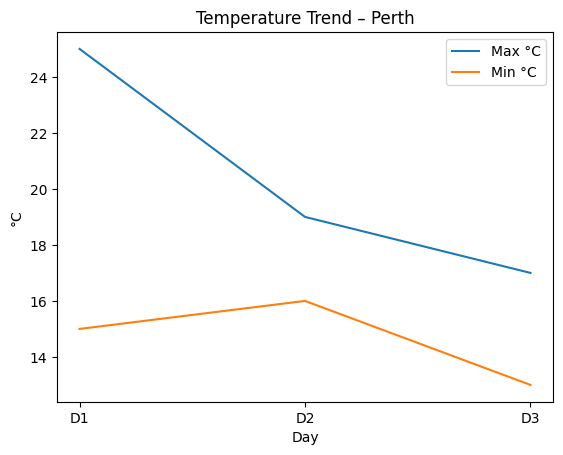

In [30]:
# Define create_temperature_visualisation() and create_precipitation_visualisation() here
def create_temperature_visualisation(weather_data, output_type='display'):
    """
    Create visualisation of temperature data.

    Args:
        weather_data (dict): The processed weather data
        output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

    Returns:
        If output_type is 'figure', returns the matplotlib figure object
        Otherwise, displays the visualisation in the notebook
    """
    days = weather_data.get("days", []) or []
    if not days:
          raise ValueError("No forecast days in weather_data")

    xs, tmax, tmin = [], [], []
    for i, d in enumerate(days):
        xs.append(f"D{i+1}")
        tmax.append(float(d.get("maxtempC", 0.0)))
        tmin.append(float(d.get("mintempC", 0.0)))

    fig, ax = plt.subplots()
    ax.plot(xs, tmax, label="Max °C")
    ax.plot(xs, tmin, label="Min °C")
    ax.set_title("Temperature Trend – " + str(weather_data.get("location","")))
    ax.set_xlabel("Day")
    ax.set_ylabel("°C")
    ax.legend()

    if output_type == "figure":
        return fig
    plt.show()
    return None

wd = get_weather_data("Perth", 3)
create_temperature_visualisation(wd)

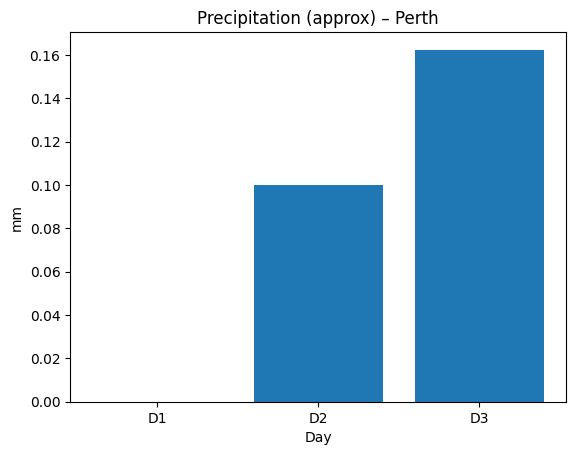

In [31]:
def create_precipitation_visualisation(weather_data, output_type='display', method="mean24"):
    """
    Create visualisation of precipitation data.

    Args:
        weather_data (dict): The processed weather data
        output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

    Returns:
        If output_type is 'figure', returns the matplotlib figure object
        Otherwise, displays the visualisation in the notebook
    """

    """
    Bar chart of approximate daily precipitation (mm).
    method: 'mean8' | 'mean24' | 'sum'  (uses daily_precip_mm helper)
    """
    days = weather_data.get("days", [])
    if not days:
        raise ValueError("No forecast days in weather_data")

    def daily_precip_mm(day, method="mean24"):
      hourly = day.get("hourly", []) or []
      vals = []
      hours = hourly[:8] if method == "mean8" else hourly
      for h in hours:
        try:
            vals.append(float(h.get("precipMM", 0.0)))
        except:
            pass
      if not vals:
        return 0.0
      if method == "sum":
        return sum(vals)
      return sum(vals) / float(len(vals))

    xs, rains = [], []
    for i, d in enumerate(days):
        xs.append(f"D{i+1}")
        # requires daily_precip_mm(day, method) defined in previous cell
        mm = daily_precip_mm(d, method=method)
        rains.append(mm)

    fig, ax = plt.subplots()
    ax.bar(xs, rains)
    ax.set_title(f"Precipitation (approx) – {weather_data.get('location','')}")
    ax.set_xlabel("Day"); ax.set_ylabel("mm")

    if output_type == "figure":
        return fig
    plt.show()
    return None

wd = get_weather_data("Perth", 3)
create_precipitation_visualisation(wd)

## 🤖 Natural Language Processing

In [38]:
# Define parse_weather_question() and generate_weather_response() here

def parse_weather_question(question):
    """
    Parse a natural language weather question.

    Args:
        question (str): User's weather-related question

    Returns:
        dict: Extracted information including location, time period, and weather attribute
    """
    import re
    q = (question or "").lower().strip()

    # location: 'in <place>' or '@<place>'
    loc = None
    m = re.search(r"(in|@)\s+([a-z\- \t]+)", q)
    if m:
        loc = m.group(2).strip()

    # attribute (intent)
    if ("rain" in q) or ("umbrella" in q) or ("precip" in q) or ("wet" in q):
        attr = "rain"
    elif ("wind" in q) or ("windy" in q) or ("gust" in q):
        attr = "wind"
    else:
        attr = "temp"

    # time period → day_index: 0=today, 1=tomorrow, 2=day-after
    if ("day after" in q) or ("d3" in q) or ("in two days" in q):
        day_idx = 2
    elif ("tomorrow" in q) or ("d2" in q):
        day_idx = 1
    else:
        day_idx = 0

    return {"location": loc, "attribute": attr, "day_index": day_idx}


## 🧭 User Interface

In [39]:
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
except Exception:
    %pip install ipywidgets --quiet
    import ipywidgets as widgets
    from IPython.display import display, clear_output

def _clean_location(raw):
    if not raw:
        return raw
    stop = {"today","tomorrow","tonight","day","after","weekend","week","d2","d3"}
    parts = str(raw).lower().strip().split()
    kept = []
    for w in parts:
        if w in stop:
            break
        kept.append(w)
    return " ".join(kept).strip().title()

def _check_core():
    missing = [name for name in [
        "get_weather_data",
        "create_temperature_visualisation",
        "create_precipitation_visualisation",
        "parse_weather_question",
        "generate_weather_response",
    ] if name not in globals()]
    if missing:
        raise RuntimeError("Please run the cells that define these functions first: "
                           + ", ".join(missing))

loc_w    = widgets.Text(value="Perth", description="Location:")
days_w   = widgets.IntSlider(value=3, min=1, max=5, step=1, description="Days:")
method_w = widgets.Dropdown(options=["mean24","mean8","sum"], value="mean24",
                            description="Rain & calc:")
run_btn  = widgets.Button(description="Fetch & Plot", button_style="primary")

q_w      = widgets.Text(value="Will it rain in Perth tomorrow?", description="Question:")
ask_btn  = widgets.Button(description="Ask")

out = widgets.Output()

def on_run_clicked(_):
    with out:
        clear_output()
        try:
            _check_core()
            loc = _clean_location(loc_w.value) or "Perth"
            wd = get_weather_data(loc, forecast_days=days_w.value)
            print(f"Fetched {len(wd.get('days', []))} day(s) for {wd.get('location')}")
            create_temperature_visualisation(wd)
            create_precipitation_visualisation(wd, method=method_w.value)
        except Exception as e:
            print("Error:", e)

def on_ask_clicked(_):
    with out:
        try:
            _check_core()
            parsed = parse_weather_question(q_w.value)
            if parsed.get("location"):
                parsed["location"] = _clean_location(parsed["location"]) or _clean_location(loc_w.value) or "Perth"
            else:
                parsed["location"] = _clean_location(loc_w.value) or "Perth"

            wd = get_weather_data(parsed["location"], forecast_days=days_w.value)
            print(generate_weather_response(parsed, wd))
        except Exception as e:
            print("Error:", e)

run_btn.on_click(on_run_clicked)
ask_btn.on_click(on_ask_clicked)

ui = widgets.VBox([
    widgets.HBox([loc_w, days_w, method_w, run_btn]),
    widgets.HBox([q_w, ask_btn]),
    out
])


## 🧩 Main Application Logic

In [40]:
# Tie everything together here
def generate_weather_response(parsed_question, weather_data):
    """
    Generate a natural language response to a weather question.

    Args:
        parsed_question (dict): Parsed question data
        weather_data (dict): Weather data

    Returns:
        str: Natural language response
    """
def generate_weather_response(parsed_question, weather_data):
    day_idx = int(parsed_question.get("day_index", 0))
    days = weather_data.get("days", []) or []
    if not days:
        return "I couldn't retrieve the forecast."
    if day_idx >= len(days):
        day_idx = 0

    d = days[day_idx]
    loc = weather_data.get("location", "your location")
    attr = parsed_question.get("attribute", "temp")

    if attr == "rain":
        hourly = d.get("hourly", []) or []
        precip = 0.0
        if hourly:
            try:
                precip = float(hourly[0].get("precipMM", 0.0))
            except:
                precip = 0.0
        tip = "Bring an umbrella." if precip >= 1.0 else "Unlikely to rain much."
        return f"In {loc} on D{day_idx+1}, expected precipitation ~{precip:.1f} mm. {tip}"

    if attr == "wind":
        hourly = d.get("hourly", []) or []
        wind = hourly[0].get("windspeedKmph", "NA") if hourly else "NA"
        return f"In {loc} on D{day_idx+1}, typical wind speed ~{wind} km/h."

    # default: temperature
    tmax = d.get("maxtempC", "NA")
    tmin = d.get("mintempC", "NA")
    return f"In {loc} on D{day_idx+1}, temperature ranges from {tmin}°C to {tmax}°C."


## 🧪 Testing and Examples

In [41]:
# Include sample input/output for each function
display(ui)

## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.